<h1> <b> Predicting Fuel Efficiency of Vehicles </b></h1>

In [1]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

In [2]:
# importing a few general use case libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading the .data file using pandas
# Look for attribute info at https://archive.ics.uci.edu/ml/datasets/Auto+MPG

cols = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv('./auto-mpg.data', names=cols, na_values = "?", comment = '\t', sep = " ", skipinitialspace = True)

data = df.copy()

In [4]:
data.sample(20) # extract sample 20 rows

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
307,26.8,6,173.0,115.0,2700.0,12.9,79,1
21,24.0,4,107.0,90.0,2430.0,14.5,70,2
390,32.0,4,144.0,96.0,2665.0,13.9,82,3
150,26.0,4,108.0,93.0,2391.0,15.5,74,3
348,37.7,4,89.0,62.0,2050.0,17.3,81,3
249,19.9,8,260.0,110.0,3365.0,15.5,78,1
375,36.0,4,105.0,74.0,1980.0,15.3,82,2
15,22.0,6,198.0,95.0,2833.0,15.5,70,1
148,26.0,4,116.0,75.0,2246.0,14.0,74,2
124,11.0,8,350.0,180.0,3664.0,11.0,73,1


## Problem Statement

The data containes MPG variable which is continuous data and tells us about the efficiency of fuel consumption of a vehicle in 70s and 80s

Our aim here is to <b>predict the MPG value for a vehicle</b> given we have other atributes of that vehicle.

## Exploratory Data Analysis

1. Check for Data type of columns
2. Check for null values
3. Check for outliers
4. Look for the category distribution in categorical columns
5. Plot for correlation
6. Look for new variables

In [5]:
# Check for Data type of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
MPG             398 non-null float64
Cylinders       398 non-null int64
Displacement    398 non-null float64
Horsepower      392 non-null float64
Weight          398 non-null float64
Acceleration    398 non-null float64
Model Year      398 non-null int64
Origin          398 non-null int64
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [6]:
# Check for null values
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# summary statistics of quantitative variable
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


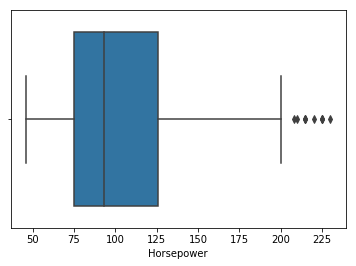

In [8]:
sns.boxplot(x=data['Horsepower'])

In [9]:
# As there are not many outliers, we will use median for null values
# Inputing the values with median
median = data['Horsepower'].median()
data['Horsepower'] = data['Horsepower'].fillna(median)

In [10]:
# Category distribution
data['Cylinders'].value_counts() / len(data)

4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: Cylinders, dtype: float64

In [11]:
data['Origin'].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

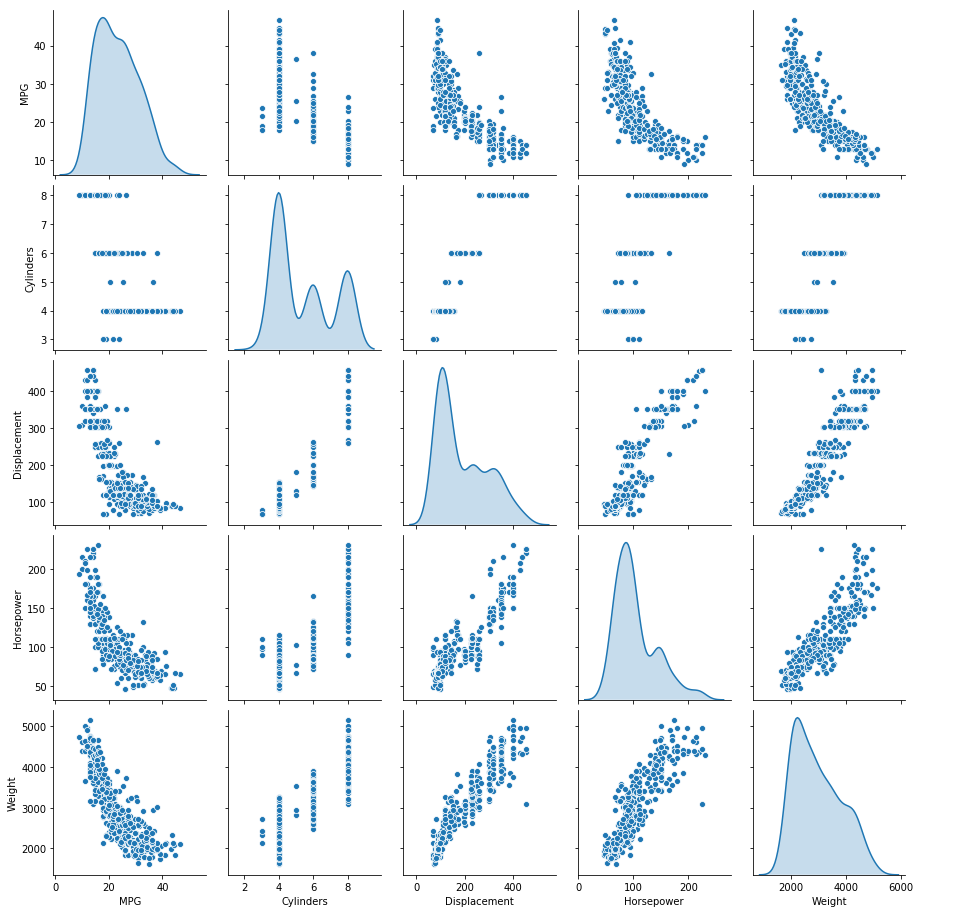

In [12]:
# Pairplots to get an intuition of potential correlations
sns.pairplot(data[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight']], diag_kind="kde")

## Data Preparation

1. Handling Categorical Attribute - OneHotEncoding
2. Data Cleaning - Imputer
3. Attribute Addition - Adding custom transformation
4. Setting up Data Transformation Pipeline for numerical and categorical column

In [13]:
# Splitting the data into training and testing

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Cylinders"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

## Segregating Target and Feature variables

In [14]:
data = strat_train_set.drop("MPG", axis=1)
data_labels = strat_train_set["MPG"].copy()

## Preprocessing the Origin Column

In [15]:
def preprocess_origin_cols(df):
    df["Origin"] = df["Origin"].map({1: "India", 2: "USA", 3: "Germany"})
    return df
data_tr = preprocess_origin_cols(data)
data_tr.head() # data transformed

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,Germany
151,4,79.0,67.0,2000.0,16.0,74,USA
388,4,156.0,92.0,2585.0,14.5,82,India
48,6,250.0,88.0,3139.0,14.5,71,India
114,4,98.0,90.0,2265.0,15.5,73,USA


## One Hot Encoding the Origin Column

In [16]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 145 to 362
Data columns (total 7 columns):
Cylinders       318 non-null int64
Displacement    318 non-null float64
Horsepower      318 non-null float64
Weight          318 non-null float64
Acceleration    318 non-null float64
Model Year      318 non-null int64
Origin          318 non-null object
dtypes: float64(4), int64(2), object(1)
memory usage: 19.9+ KB


In [17]:
# isolating the origin column

data_cat = data_tr[["Origin"]]
data_cat.head()

,Origin
145,Germany
151,USA
388,India
48,India
114,USA


In [18]:
# onehotencoding the categorical values
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(data_cat)
data_cat_1hot 

<318x3 sparse matrix of type '<class 'numpy.float64'>'
	with 318 stored elements in Compressed Sparse Row format>

In [19]:
data_cat_1hot.toarray()[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [20]:
cat_encoder.categories_

[array(['Germany', 'India', 'USA'], dtype=object)]

## Handing Missing values using SimpleImputer

In [21]:
## Segregating the numerical columns
num_data = data.iloc[:, :-1]
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 145 to 362
Data columns (total 6 columns):
Cylinders       318 non-null int64
Displacement    318 non-null float64
Horsepower      318 non-null float64
Weight          318 non-null float64
Acceleration    318 non-null float64
Model Year      318 non-null int64
dtypes: float64(4), int64(2)
memory usage: 17.4 KB


In [22]:
## handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(num_data)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [23]:
# median of all the columns from imputer
imputer.statistics_

array([   4. ,  146. ,   93.5, 2844. ,   15.5,   76. ])

In [24]:
# median from pandas dataframe - same
data.median().values

array([   4. ,  146. ,   93.5, 2844. ,   15.5,   76. ])

In [25]:
# imputing the missing values by transforming the dataframe
X = imputer.transform(num_data)
X

array([[   4. ,   83. ,   61. , 2003. ,   19. ,   74. ],
       [   4. ,   79. ,   67. , 2000. ,   16. ,   74. ],
       [   4. ,  156. ,   92. , 2585. ,   14.5,   82. ],
       ...,
       [   4. ,  135. ,   84. , 2295. ,   11.6,   82. ],
       [   4. ,  113. ,   95. , 2372. ,   15. ,   70. ],
       [   6. ,  146. ,  120. , 2930. ,   13.8,   81. ]])

In [26]:
# converting the 2D array back into a dataframe
data_tr = pd.DataFrame(X, columns=num_data.columns, index=num_data.index)

data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 145 to 362
Data columns (total 6 columns):
Cylinders       318 non-null float64
Displacement    318 non-null float64
Horsepower      318 non-null float64
Weight          318 non-null float64
Acceleration    318 non-null float64
Model Year      318 non-null float64
dtypes: float64(6)
memory usage: 17.4 KB


In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

acc_ix, hpower_ix, cyl_ix = 4, 2, 0

class CustomAttrAdder(BaseEstimator, TransformerMixin):
    def __init__(self, acc_on_power=True): #no *args or **kargs
        self.acc_on_power = acc_on_power
    def fit(self, X, y = None):
        return self # nothing else to do
    def transform(self, X):
        acc_on_cyl = X[:, acc_ix] / X[:, cyl_ix]
        if self.acc_on_power:
            acc_on_power = X[:, acc_ix] / X[:, hpower_ix]
            return np.c_[X, acc_on_power, acc_on_cyl]
        
        return np.c_[X, acc_on_cyl]

attr_adder = CustomAttrAdder(acc_on_power = True)
data_tr_extra_attrs = attr_adder.transform(data_tr.values)
data_tr_extra_attrs[0]
    
        

array([4.0000000e+00, 8.3000000e+01, 6.1000000e+01, 2.0030000e+03,
       1.9000000e+01, 7.4000000e+01, 3.1147541e-01, 4.7500000e+00])

## Create a Pipeline of tasks

In [28]:
numerics = ['float64', 'int64']
num_data = data_tr.select_dtypes(include = numerics)

# pipeline for numerical attributes
# imputing -> adding attributes -> scale them
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attrs_adder', CustomAttrAdder()),
    ('std_scaler', StandardScaler()),
])

num_data_tr = num_pipeline.fit_transform(num_data)
num_data_tr[0]

array([-0.85657842, -1.07804475, -1.15261228, -1.17220298,  1.21586943,
       -0.54436373,  1.71003081,  1.29565517])

## Transforming Numerical and Categorical Attributes

In [29]:
# Transform different columns or subsets using ColumnTransformer
from sklearn.compose import ColumnTransformer

num_attrs = list(num_data)
cat_attrs = ["Origin"]

# complete pipeline to transform
# both numerical and cat. attributes
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", OneHotEncoder(), cat_attrs),
])

prepared_data = full_pipeline.fit_transform(data)
prepared_data[0]

array([-0.85657842, -1.07804475, -1.15261228, -1.17220298,  1.21586943,
       -0.54436373,  1.71003081,  1.29565517,  1.        ,  0.        ,
        0.        ])